# Computer Vision CSCI-GA.2272-001 Assignment 1

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch, modify this ipython notebook

To install PyTorch, follow instructions at http://pytorch.org/

Please email your assignment to the graders: Yi-Hsiang Kao (ykh342@nyu.edu) and Anshul Sharma (as10950@nyu.edu).

## Warmup [10%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **

## Training a Single Layer Network on MNIST [20%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 50,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.
(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Training a Multi-Layer Network on MNIST [20%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.
-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

## Training a Convolutional Network on CIFAR [50%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

- Give a breakdown of the parameters within the above model, and the overall number.

In [1]:
from __future__ import print_function
import argparse

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import Sampler
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

%matplotlib inline

In [2]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [3]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

# Warmup 
* Visualize images of respective dataset.
* Change the dataset in options cell above to visualize the other datset.

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

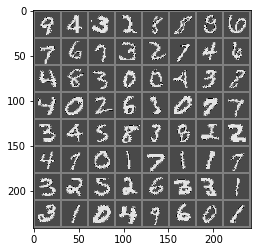

In [5]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))

In [6]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [7]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:
torch.manual_seed(999)

In [9]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.289023
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.600593
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.438814
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.377848
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.667385
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.458048
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.249779
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.262537
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.204298
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.281294

Test set: Average loss: 0.3320, Accuracy: 9077/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.393739
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.536051
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.206902
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.314321
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.377064
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.327125
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.252235
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.328723
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.171845
T

# Training a Single Layer Network on MNIST 

### (a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: #1 #2 )

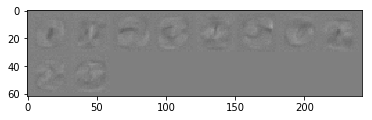

In [10]:
for x in network.modules():
    if isinstance(x, nn.Linear):
        imshow(utils.make_grid(x.weight.data.view(10,1,28,28)))

### (b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the train function]. Paste the output into your report and explain what is happening to the model.

In [11]:
# Implementing Sampler interface to sample X datapoints from the dataset in a fixed order
class SubsetSampler(Sampler):
    def __init__(self, data_source, num_samples):
        self.data_source = data_source
        if num_samples > len(self.data_source):
            self.num_samples = len(self.data_source)
        else:
            self.num_samples = num_samples
            
    def __iter__(self):
        return iter(range(self.num_samples))

    def __len__(self):
        return self.num_samples

In [12]:
# Limiting training examples to just 50, by passing subset_sampler to DataLoader
subset_sampler = SubsetSampler(trainset, 50) 
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, sampler=subset_sampler, num_workers=0)

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [13]:
for epoch in range(1, epochs+1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.984178

Test set: Average loss: 1.5825, Accuracy: 5117/10000 (51%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.343531

Test set: Average loss: 1.3786, Accuracy: 5755/10000 (58%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.076344

Test set: Average loss: 1.3046, Accuracy: 6029/10000 (60%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.050111

Test set: Average loss: 1.2984, Accuracy: 6071/10000 (61%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.041455

Test set: Average loss: 1.2955, Accuracy: 6075/10000 (61%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.035248

Test set: Average loss: 1.2942, Accuracy: 6081/10000 (61%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.030733

Test set: Average loss: 1.2939, Accuracy: 6093/10000 (61%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.027320

Test set: Average loss: 1.2941, Accuracy: 6098/10000 (61%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.024647

Test set: Average loss: 1.2947, Accuracy: 6113/10000 (61%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.022491


## The model overfits the training set after limiting it to 50 samples. As we can see clearly from the above result with each epoch, the training loss is substantially reduced to nearly 0 but on the contrary the accuracy on the test set has gone down significantly to ~64%

# Training a Multi-Layer Network on MNIST

### a) Add an extra layer to the network with 1000 hidden units and a tanh non-linearity. [Hint: modify the Net class]. Train the model for 10 epochs and save the output into your report.


In [14]:
# as we need to train model on entire dataset again
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

In [15]:
n_hidden = 1000

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, n_hidden):
        super(Net, self).__init__()
        self.net = nn.Sequential(nn.Linear(num_inputs, n_hidden),
              nn.Tanh(),
              nn.Linear(n_hidden, num_outputs))
    

    def forward(self, x):
        x = x.view(-1, num_inputs) # reshape input to batch x num_inputs
        return self.net(x)

network = Net(num_inputs, num_outputs, n_hidden)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [16]:
for epoch in range(1, 1 + epochs):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.349533
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.845054
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.495964
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.362735
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.384280
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.275970
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.313863
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.299337
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.328717
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.315040

Test set: Average loss: 0.3238, Accuracy: 9101/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.291884
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.392521
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.380243
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.296790
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.353150
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.229532
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.393590
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.228714
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.255664
T

### b) Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

In [17]:
network = Net(num_inputs, num_outputs, n_hidden)
optimizer = optim.SGD(network.parameters(), lr=10)

In [18]:
for epoch in range(1, 1 + epochs):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.387463
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1917.377319
Train Epoch: 1 [12800/60000 (21%)]	Loss: 717.873962
Train Epoch: 1 [19200/60000 (32%)]	Loss: 968.631042
Train Epoch: 1 [25600/60000 (43%)]	Loss: 565.619141
Train Epoch: 1 [32000/60000 (53%)]	Loss: 282.198395
Train Epoch: 1 [38400/60000 (64%)]	Loss: 269.738159
Train Epoch: 1 [44800/60000 (75%)]	Loss: 254.430573
Train Epoch: 1 [51200/60000 (85%)]	Loss: 205.353210
Train Epoch: 1 [57600/60000 (96%)]	Loss: 872.105835

Test set: Average loss: 494.8711, Accuracy: 6476/10000 (65%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 428.343506
Train Epoch: 2 [6400/60000 (11%)]	Loss: 338.300140
Train Epoch: 2 [12800/60000 (21%)]	Loss: 58.206413
Train Epoch: 2 [19200/60000 (32%)]	Loss: 449.609161
Train Epoch: 2 [25600/60000 (43%)]	Loss: 344.196991
Train Epoch: 2 [32000/60000 (53%)]	Loss: 244.112381
Train Epoch: 2 [38400/60000 (64%)]	Loss: 248.942764
Train Epoch: 2 [44800/60000 (75%)]	Loss: 125.787842
Train Epoch: 2 

###  If the learning rate is set too high, it can cause undesirable divergence in the loss function.
The learning rate can be seen as step size, η. As such, gradient descent is taking successive steps in the direction of the minimum. If the step size η is too large, it can (plausibly) "jump over" the minima we are trying to reach, ie. we overshoot. This can lead to osculations around the minimum or in some cases to outright divergence.

* Source: https://stats.stackexchange.com/questions/315664/gradient-descent-explodes-if-learning-rate-is-too-large



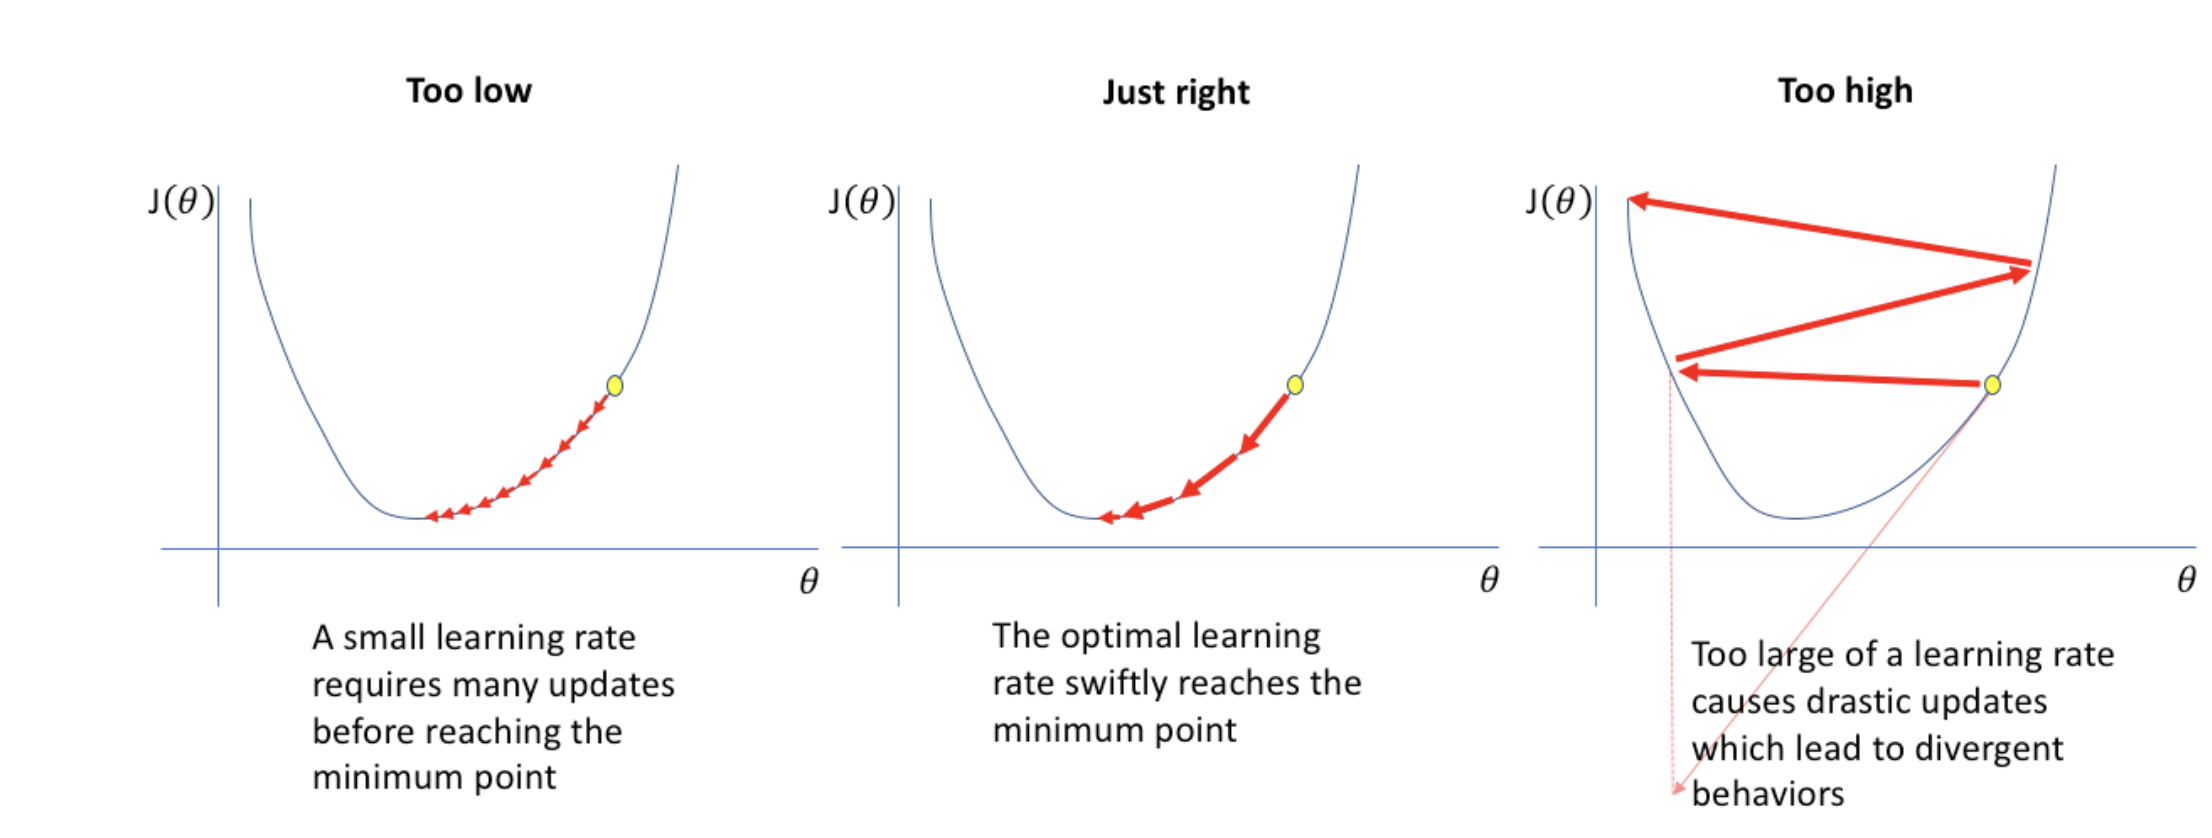

### Source: https://www.jeremyjordan.me/nn-learning-rate/

## Training a Convolutional Network on CIFAR [50%]

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

### a) Train it for 20 epochs on the CIFAR-10 training set and copy the output into your report, along with a image of the first layer filters.

In [19]:
dataset= 'cifar10'

data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
num_inputs = 3072
epochs=20

class Convnet(nn.Module):
    def __init__(self, num_outputs):
        super(Convnet,self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size= 5) # 3 for channel as the image is colored, 16 feature map in 1st conv
        self.conv2 = nn.Conv2d(16, 128, kernel_size=5) # 128 feature map
        self.fc1 = nn.Linear(128*5*5, 64) # 64 hidden_units
        self.fc2 = nn.Linear(64, num_outputs) # as 10 classes
    
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.tanh(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.tanh(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    
network = Convnet(num_outputs)
print(network)    

optimizer = optim.SGD(network.parameters(), lr=lr)

Convnet(
  (conv1): Conv2d (3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (16, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=64)
  (fc2): Linear(in_features=64, out_features=10)
)


In [21]:
for epoch in range(1, 1+epochs):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.324626
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.109350
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.031258
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.990826
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.923209
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.872881
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.922463
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.720131

Test set: Average loss: 1.7862, Accuracy: 3779/10000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.885671
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.761372
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.728539
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.623628
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.650774
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.763570
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.618262
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.629695

Test set: Average loss: 1.5998, Accuracy: 4282/10000 (43%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.590268
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.607


Test set: Average loss: 0.9776, Accuracy: 6602/10000 (66%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.843642
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.594917
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.737679
Train Epoch: 19 [19200/50000 (38%)]	Loss: 1.054266
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.908116
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.833993
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.807736
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.917171

Test set: Average loss: 1.0925, Accuracy: 6318/10000 (63%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 1.129674
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.998430
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.757434
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.882190
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.626563
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.925794
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.774332
Train Epoch: 20 [44800/50000 (90%)]	Loss: 1.048744

Test set: Average loss: 0.9330, Accuracy: 6767/10000 (68%)



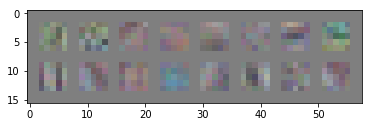

In [22]:
for x in network.modules():
    if isinstance(x, nn.Conv2d):
        imshow(utils.make_grid(x.weight.data))
        break

### b) Give a breakdown of the parameters within the above model, and the overall number.

In this convolutional network architecture:
* The input layer doesn't contribute to any parameters - 0 

* The paramters in the convolutional layer is calculated as below:
    The conv1 has l = 3 feature map as input, k = 16 feature map as output and the filter size is n=5,m=5.
    Hence we have 3x5x5 filter, as our input is 3 dim and we learn 16 different 3x5x5 filters. Thus, the total   
    number of weights is n*m*kl . Then, there is also a bias term for each feature map, so we have a total number of 
    parameters of (nml+1)k.
    
* conv1 = (5x5x3+1)x16 = 1216

* The pooling layer simply replace the 2x2 neighborhood by its maximum value, hence no parameters.

* conv2 = (5x5x16+1)*128 = 51328

* For fully connected layer with n inputs and m outputs, we have n*m weights plus bias for each output. Therefore, (n+1)*m

* fc1 = (3200+1)*64 = 204864
* fc2 = (64+1)*10 = 650

* Total = 258058

In [24]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        print(p.size())
        np += p.nelement()
    return np

print('Overall number: {}'.format(get_n_params(network)))

torch.Size([16, 3, 5, 5])
torch.Size([16])
torch.Size([128, 16, 5, 5])
torch.Size([128])
torch.Size([64, 3200])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
Overall number: 258058
